**Задача - Классификация текстовых отзывов на рестораны по важности (важный/неважный)**

---



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score

In [ ]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

### EDA

In [ ]:
df = pd.read_csv('merged_data.csv')
df.head()

/tmp/ipython-input-93-1987382785.py:1: DtypeWarning: Columns (23,24,37,42,43,52,54,55,56,60,61,62,65,67) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('merged_data.csv')


,address,business_id,is_open,name,postal_code,review_count,cool,date,funny,review_id,...,weather_heavy_shower,weather_heavy_snow,weather_light_rain,weather_light_shower,weather_light_snow,weather_moderate_rain,weather_overcast,weather_rain,weather_snow,weather_sunny
0,724 Iberville St,_ab50qdWOk0DdB6XOrBitw,1,Acme Oyster House,70130,7568,50,2018-02-26,33,1pRWgdzpjfZ7G9FcTiZhfA,...,False,False,True,False,False,False,False,False,False,False
1,724 Iberville St,_ab50qdWOk0DdB6XOrBitw,1,Acme Oyster House,70130,7568,42,2016-01-15,33,kK6WEY0D3NjQ1nSlAWnxyA,...,False,False,False,False,False,False,False,True,False,False
2,724 Iberville St,_ab50qdWOk0DdB6XOrBitw,1,Acme Oyster House,70130,7568,22,2011-05-04,28,S31eyfbmySqh4H48PJ-bNA,...,False,False,False,False,False,False,False,False,False,False
3,724 Iberville St,_ab50qdWOk0DdB6XOrBitw,1,Acme Oyster House,70130,7568,23,2017-10-20,10,_BJRPVyZpon5UWJyfafOsw,...,False,False,False,False,False,True,False,False,False,False
4,724 Iberville St,_ab50qdWOk0DdB6XOrBitw,1,Acme Oyster House,70130,7568,12,2013-07-15,9,YaDy_EaOussRy_gFDvQYNQ,...,False,False,False,False,False,False,False,True,False,False


In [ ]:
df['date'] = pd.to_datetime(df['date'])
df['dayofweek'] = df['date'].dt.dayofweek

In [ ]:
df['useful'].value_counts()

,count
useful,
0,4092
2,560
3,555
4,549
6,545
...,...
222,1
84,1
59,1


Создадим **целевую переменную для классификации является ли отзыв важным** или нет (1, 0)

In [ ]:
df['is_useful'] = (df['useful']>0).astype(int)
df.head()

,address,business_id,is_open,name,postal_code,review_count,cool,date,funny,review_id,...,weather_light_rain,weather_light_shower,weather_light_snow,weather_moderate_rain,weather_overcast,weather_rain,weather_snow,weather_sunny,dayofweek,is_useful
0,724 Iberville St,_ab50qdWOk0DdB6XOrBitw,1,Acme Oyster House,70130,7568,50,2018-02-26,33,1pRWgdzpjfZ7G9FcTiZhfA,...,True,False,False,False,False,False,False,False,0,1
1,724 Iberville St,_ab50qdWOk0DdB6XOrBitw,1,Acme Oyster House,70130,7568,42,2016-01-15,33,kK6WEY0D3NjQ1nSlAWnxyA,...,False,False,False,False,False,True,False,False,4,1
2,724 Iberville St,_ab50qdWOk0DdB6XOrBitw,1,Acme Oyster House,70130,7568,22,2011-05-04,28,S31eyfbmySqh4H48PJ-bNA,...,False,False,False,False,False,False,False,False,2,1
3,724 Iberville St,_ab50qdWOk0DdB6XOrBitw,1,Acme Oyster House,70130,7568,23,2017-10-20,10,_BJRPVyZpon5UWJyfafOsw,...,False,False,False,True,False,False,False,False,4,1
4,724 Iberville St,_ab50qdWOk0DdB6XOrBitw,1,Acme Oyster House,70130,7568,12,2013-07-15,9,YaDy_EaOussRy_gFDvQYNQ,...,False,False,False,False,False,True,False,False,0,1


In [ ]:
df.iloc[:,228:242] = df.iloc[:,228:242].astype(int)

/tmp/ipython-input-97-932613148.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       0
1       0
2       0
3       0
4       0
       ..
9727    0
9728    0
9729    0
9730    0
9731    0
Name: is_holiday, Length: 9732, dtype: int64' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.iloc[:,228:242] = df.iloc[:,228:242].astype(int)
/tmp/ipython-input-97-932613148.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       0
1       0
2       0
3       0
4       0
       ..
9727    0
9728    0
9729    0
9730    0
9731    0
Name: weather_clear, Length: 9732, dtype: int64' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.iloc[:,228:242] = df.iloc[:,228:242].astype(int)
/tmp/ipython-input-97-932613148.py:1: FutureWarning: Setting an item of incompatible dtype is

In [ ]:
df.drop(['useful','lat_rounded','lon_rounded'],axis=1,inplace=True)

<Axes: >

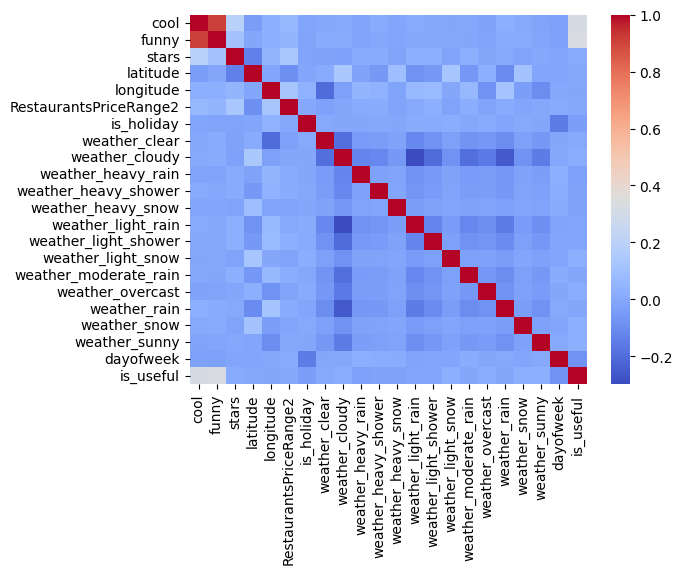

In [ ]:
sns.heatmap(df.iloc[:,6:242].select_dtypes(include=np.number).corr(),cmap='coolwarm')

**Вывод:** как видим на нашу целевую переменную is_useful слабо влияют другие числовые признаки. Хорошо коррелируют признаки реакций пользователей cool и funny, что является логичным выводом и мы не будем их использовать, так как они явно указывают на реакцию пользователей и не являются другими внешними факторами.

In [ ]:
df_rev = df.iloc[:,228:244]
df_rev['text'] =  df['text']

In [ ]:
X = df_rev.drop('is_useful', axis=1)
y = df_rev['is_useful']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### ML

TF-IDF + TruncatedSVD

In [ ]:
# Ограничим размер словаря 15000
vectorizer = TfidfVectorizer(
        input="content",
        norm="l2",
        ngram_range=(1,1),
        analyzer='word',
        min_df=2,
        max_features=15000,
        sublinear_tf=True,
        stop_words='english')

svd = TruncatedSVD(n_components=500)

tfidf_train = vectorizer.fit_transform(X_train['text'])
tfidf_test = vectorizer.transform(X_test['text'])

X_train_svd = svd.fit_transform(tfidf_train)
X_test_svd = svd.transform(tfidf_test)

X_train = np.concatenate((X_train_svd, X_train.drop('text', axis=1).values), axis=1)
X_test = np.concatenate((X_test_svd, X_test.drop('text', axis=1).values), axis=1)

1. Логистическая регрессия

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'penalty':['l1','l2'], 'tol':[0.0001, 0.001],
          'class_weight':['balanced', None], 'C':[0.5, 1, 5]}

lr_model = LogisticRegression(random_state=42, max_iter=1000)
grx = GridSearchCV(lr_model, params, scoring='accuracy')
grx.fit(X_train, y_train)
print(grx.best_score_)
print(grx.best_params_)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solve

0.7161207450224791
{'C': 1, 'class_weight': None, 'penalty': 'l2', 'tol': 0.0001}


In [ ]:
print('Logistic Regression:')
lr_model = LogisticRegression(C=1, class_weight=None,
                              penalty='l2', tol=0.0001,
                              max_iter=10000, random_state=42)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print(classification_report(y_test, y_pred_lr))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.69      0.53      0.60       819
           1       0.71      0.83      0.76      1128

    accuracy                           0.70      1947
   macro avg       0.70      0.68      0.68      1947
weighted avg       0.70      0.70      0.70      1947



2. Наивный байесовский классификатор

In [ ]:
params = {'alpha':[0.001, 0.01, 0.1, 1, 5]}

nb_model = MultinomialNB()
grx = GridSearchCV(nb_model, params, scoring='f1')
grx.fit(X_train, y_train)
print(grx.best_score_)
print(grx.best_params_)

0.7551827302949061
{'alpha': 0.01}


In [ ]:
print('Naive Bayes:')
nb_model = MultinomialNB(alpha=0.01)
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
print(classification_report(y_test, y_pred_nb))

Naive Bayes:
              precision    recall  f1-score   support

           0       0.66      0.46      0.54       819
           1       0.68      0.83      0.75      1128

    accuracy                           0.67      1947
   macro avg       0.67      0.65      0.65      1947
weighted avg       0.67      0.67      0.66      1947



3. Линейный SVM

In [ ]:
params = {'C': [0.01, 0.1, 1, 10], 'loss': ['hinge', 'squared_hinge'],
          'class_weight': [None, 'balanced']}

svm_model = LinearSVC(random_state=42)
grx = GridSearchCV(svm_model, params, scoring='f1')
grx.fit(X_train, y_train)
print(grx.best_score_)
print(grx.best_params_)

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

0.7766060600815563
{'C': 0.1, 'class_weight': None, 'loss': 'squared_hinge'}


In [ ]:
print('Linear SVM:')
svm_model = LinearSVC(C=0.1, loss='squared_hinge', random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print(classification_report(y_test, y_pred_svm))

Linear SVM:
              precision    recall  f1-score   support

           0       0.69      0.52      0.60       819
           1       0.71      0.83      0.76      1128

    accuracy                           0.70      1947
   macro avg       0.70      0.68      0.68      1947
weighted avg       0.70      0.70      0.69      1947



4. Случайный лес

In [ ]:
params = {'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['log2','square']}

rf_model = RandomForestClassifier(random_state=42)
grx = GridSearchCV(rf_model, params, scoring='f1')
grx.fit(X_train, y_train)
print(grx.best_score_)
print(grx.best_params_)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
270 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
270 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/util

0.7858294487002176
{'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
print('Random Forest:')
rf_model = RandomForestClassifier(max_features='log2', min_samples_leaf=2, max_depth=None,
                                  min_samples_split=2, n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

Random Forest:
              precision    recall  f1-score   support

           0       0.75      0.49      0.59       819
           1       0.70      0.88      0.78      1128

    accuracy                           0.72      1947
   macro avg       0.73      0.68      0.69      1947
weighted avg       0.72      0.72      0.70      1947



5. Градиентный бустинг

In [ ]:
print('Gradient Boosting:')
gb_model = GradientBoostingClassifier(max_features='log2', min_samples_leaf=2, max_depth=None,
                                  min_samples_split=2, n_estimators=200, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
print(classification_report(y_test, y_pred_gb))

Gradient Boosting:
              precision    recall  f1-score   support

           0       0.71      0.63      0.67       819
           1       0.75      0.81      0.78      1128

    accuracy                           0.74      1947
   macro avg       0.73      0.72      0.72      1947
weighted avg       0.73      0.74      0.73      1947



Сравнение результатов работы моделей машинного обучения

In [ ]:
def evaluate(model_name, y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    accuracy = report['accuracy']
    f1_score = report['macro avg']['f1-score']
    results.loc[len(results)] = [model_name, accuracy, f1_score]

In [ ]:
results = pd.DataFrame(columns=['Model', 'Accuracy', 'F1-Score'])

evaluate("Logistic Regression", y_test, y_pred_lr)
evaluate("Naive Bayes", y_test, y_pred_nb)
evaluate("Linear SVM", y_test, y_pred_svm)
evaluate("Random Forest", y_test, y_pred_rf)
evaluate("Gradient Boosting", y_test, y_pred_gb)

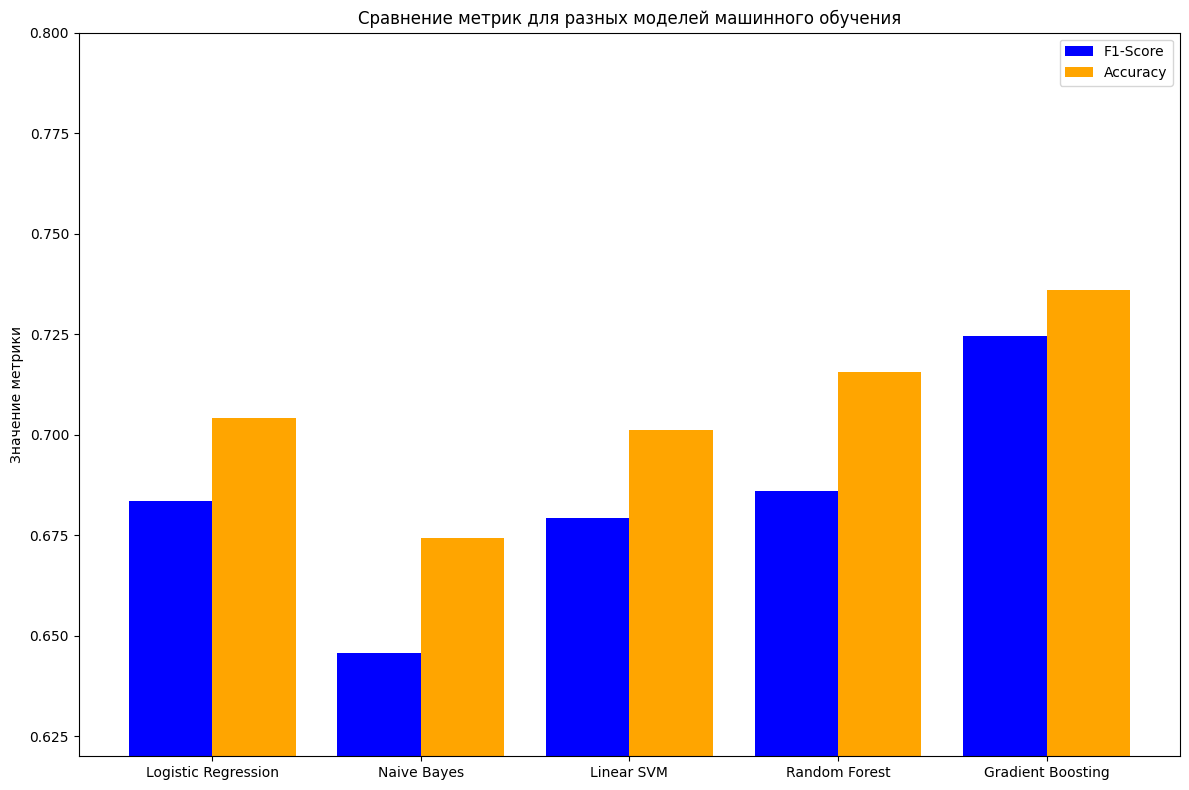

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(results['Model']))
width = 0.4
rects1 = ax.bar(x-width/2, results['F1-Score'], width, label='F1-Score', color='blue')
rects2 = ax.bar(x+width/2, results['Accuracy'], width, label='Accuracy', color='orange')
ax.set_ylabel('Значение метрики')
ax.set_title('Сравнение метрик для разных моделей машинного обучения')
ax.set_xticks(x)
ax.set_xticklabels(results['Model'])
ax.set_ylim(0.62, 0.8)
ax.legend()
plt.tight_layout()
plt.show()

**Вывод:**

Для решения залачи классификации отзывов было использовано 5 различных моделей машинного обучения: Logistic Regression, Naive Bayes, Linear SVM, Random Forest и Gradient Boosting. Для каждой модели были подобраны наилучшие гиперпараметры с помощью GridSearch.

В качестве метрик оценки были выбраны accuracy (доля правильных ответов) и F1-score, который является гармоническим средним между precision (точность) и recall (полнота).

В качестве предобработки данных были использованы TF-IDF для перевода текста в числовое (векторное) представление и TruncatedSVD(усеченная декомпозиция сингулярных значений) для уменьшения размерности данных. Это позволило настроить текстовые данные для работы моделей машинного обучения.

По результатам, **наилучшее качество по обеим метрикам для решения задачи показала модель градиентного бустинга (Gradient Boosting), уступает ей модели случайного леса (Random Forest), логистическая регрессия (Logistic Regression) и SVM, наихудший результат показал наивный байесовский классификатор(Naive Bayes)**.

Gradient Boosting оказался лучшим, так как строит ансамбль моделей последовательно, при этом каждая последующая модель пытается исправить ошибки предыдущих. Это позволяет модели постепенно улучшать свои предсказания и достигать более высокой точности.

Детальный анализ каждой модели:

1. Logistic Regression: accuracy - 70.42%, F1-Score - 68.35%.
Logistic Regression показывает среднюю производительность. Это линейная модель, которая пытается найти оптимальную гиперплоскость для разделения классов. Она достаточно проста и быстра в обучении, но может не справляться со сложными нелинейными зависимостями в данных.

2. Naive Bayes: accuracy - 67.44%, F1-Score - 64.56%.
Naive Bayes демонстрирует наихудшую производительность среди всех моделей. Это связано с упрощающим предположением о независимости признаков, которое часто не выполняется в текстовых данных (слова в отзыве взаимосвязаны).

3. Linear SVM: accuracy - 70.11%, F1-Score - 67.93%.
Linear SVM показывает схожую производительность с Logistic Regression. Он также является линейной моделью, но использует другой подход для нахождения разделяющей гиперплоскости, максимизируя маржу между классами.

4. Random Forest: accuracy - 71.55%, F1-Score - 68.59%.
Random Forest показывает улучшение по сравнению с линейными моделями. Это ансамблевый метод, который строит множество решающих деревьев и усредняет их предсказания. Он хорошо справляется с нелинейными зависимостями и устойчив к переобучению.

5. Gradient Boosting: accuracy - 73.60%, F1-Score - 72.44%.
Gradient Boosting демонстрирует наилучшую производительность среди всех моделей. Это еще один ансамблевый метод, который строит деревья последовательно, каждый раз исправляя ошибки предыдущих деревьев. Он часто обеспечивает очень высокую точность, но может быть более подвержен переобучению, чем Random Forest.



**Без учета признаков, только текст**

Проверим гипотезу о том, что другие признаки (погода, праздник, ресторан) не сильно влияют на качество модели.

In [ ]:
print('Logistic Regression:')
lr_model = LogisticRegression(C=1, class_weight=None,
                              penalty='l2', tol=0.00005,
                              max_iter=10000, random_state=42)
lr_model.fit(tfidf_train, y_train)
y_pred_lr_text = lr_model.predict(tfidf_test)
print(classification_report(y_test, y_pred_lr_text))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.69      0.56      0.62       819
           1       0.72      0.82      0.77      1128

    accuracy                           0.71      1947
   macro avg       0.70      0.69      0.69      1947
weighted avg       0.71      0.71      0.70      1947



In [ ]:
print('Naive Bayes:')
nb_model = MultinomialNB(alpha=0.01)
nb_model.fit(tfidf_train, y_train)
y_pred_nb_text = nb_model.predict(tfidf_test)
print(classification_report(y_test, y_pred_nb_text))

Naive Bayes:
              precision    recall  f1-score   support

           0       0.68      0.42      0.51       819
           1       0.67      0.86      0.75      1128

    accuracy                           0.67      1947
   macro avg       0.67      0.64      0.63      1947
weighted avg       0.67      0.67      0.65      1947



In [ ]:
print('Linear SVM:')
svm_model = LinearSVC(C=0.1, loss='squared_hinge', random_state=42)
svm_model.fit(tfidf_train, y_train)
y_pred_svm_text = svm_model.predict(tfidf_test)
print(classification_report(y_test, y_pred_svm_text))

Linear SVM:
              precision    recall  f1-score   support

           0       0.69      0.57      0.62       819
           1       0.72      0.82      0.77      1128

    accuracy                           0.71      1947
   macro avg       0.71      0.69      0.69      1947
weighted avg       0.71      0.71      0.71      1947



In [ ]:
print('Random Forest:')
rf_model = RandomForestClassifier(max_features='log2', min_samples_leaf=2, max_depth=None,
                                  min_samples_split=2, n_estimators=200, random_state=42,
                                  criterion='log_loss')
rf_model.fit(tfidf_train, y_train)
y_pred_rf_text = rf_model.predict(tfidf_test)
print(classification_report(y_test, y_pred_rf_text))

Random Forest:
              precision    recall  f1-score   support

           0       0.73      0.51      0.60       819
           1       0.71      0.87      0.78      1128

    accuracy                           0.72      1947
   macro avg       0.72      0.69      0.69      1947
weighted avg       0.72      0.72      0.71      1947



In [ ]:
print('Gradient Boosting:')
gb_model = GradientBoostingClassifier(max_features='log2', min_samples_leaf=2, max_depth=None,
                                  min_samples_split=2, n_estimators=200, random_state=42)
gb_model.fit(tfidf_train, y_train)
y_pred_gb_text = gb_model.predict(tfidf_test)
print(classification_report(y_test, y_pred_gb_text))

Gradient Boosting:
              precision    recall  f1-score   support

           0       0.70      0.62      0.65       819
           1       0.74      0.81      0.77      1128

    accuracy                           0.73      1947
   macro avg       0.72      0.71      0.71      1947
weighted avg       0.72      0.73      0.72      1947



Вывод:
Как видим учет только текста комментариев во многом сильно не меняется качество моделей. Качество метрик улучшилось на 1% в линейных моделях Logistic Regression, Linear SVM, ухудшилось на 1% для деревьев - Random Forest и Gradient Boosting, и не изменилось для Naive Bayes.

Таким образом, другие признаки, такие как **погодные условия, наличия праздника в день написания отзыва, особенности ресторана** совершенно **незначительно влияют на качество классификации отзывов по важности**, а значит, незначительно влияют на реакции пользователей о важности отзыва.

### DL

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, Conv1D, MaxPooling1D,
                                   Bidirectional, LSTM, Dense, Dropout,
                                   MultiHeadAttention, LayerNormalization,
                                   GlobalMaxPooling1D, concatenate)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score
import nltk
import re
from nltk.corpus import stopwords
import torch

In [ ]:
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', str(text), re.UNICODE)
    text = text.lower()
    text = [token for token in text.split(" ") if token not in stop_words]
    text = " ".join(text)
    return text

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

X = df_rev['text'].apply(lambda x: clean_text(x))
y = df_rev['is_useful']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Максимальная длина отзыва 200, словарь 15000
max_len = 200
tokenizer = Tokenizer(num_words=15000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [ ]:
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title}: Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title}: Accuracy')
    plt.legend()
    plt.show()

In [ ]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    print(f"\n{model_name} Results:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3)]

1. CNN

In [ ]:
def build_cnn(vocab_size=15000, embedding_dim=256, max_length=200):
    input_layer = Input(shape=(max_length,))

    x = Embedding(vocab_size, embedding_dim, input_length=max_length)(input_layer)
    x = Dropout(0.3)(x)

    conv1 = Conv1D(256, 3, activation='relu', padding='same')(x)
    conv1 = MaxPooling1D(2)(conv1)

    conv2 = Conv1D(256, 4, activation='relu', padding='same')(x)
    conv2 = MaxPooling1D(2)(conv2)

    conv3 = Conv1D(256, 5, activation='relu', padding='same')(x)
    conv3 = MaxPooling1D(2)(conv3)

    merged = concatenate([conv1, conv2, conv3])
    merged = Conv1D(128, 3, activation='relu')(merged)
    merged = GlobalMaxPooling1D()(merged)

    dense = Dense(128, activation='relu')(merged)
    dense = Dropout(0.25)(dense)
    dense = Dense(64, activation='relu')(dense)
    output = Dense(1, activation='sigmoid')(dense)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
cnn = build_cnn()
history_cnn = cnn.fit(
        X_train_pad, y_train,
        validation_split=0.2,
        epochs=30,
        batch_size=64,
        callbacks=callbacks,
        verbose=1)

Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.5771 - loss: 0.6730 - val_accuracy: 0.5999 - val_loss: 0.6523 - learning_rate: 1.0000e-04
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6286 - loss: 0.6456 - val_accuracy: 0.6307 - val_loss: 0.6320 - learning_rate: 1.0000e-04
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6948 - loss: 0.6096 - val_accuracy: 0.6904 - val_loss: 0.5886 - learning_rate: 1.0000e-04
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7555 - loss: 0.5233 - val_accuracy: 0.7129 - val_loss: 0.5668 - learning_rate: 1.0000e-04
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8064 - loss: 0.4380 - val_accuracy: 0.7046 - val_loss: 0.5986 - learning_rate: 1.0000e-04
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8509 - loss: 0.3473 - val_accuracy: 0.7123 - val_loss: 0.6217 - learning_rate: 1.0000e-04
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8773

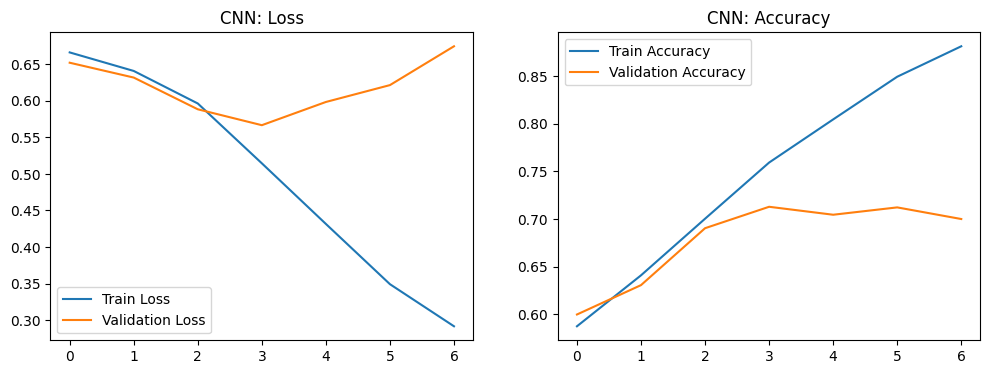

In [ ]:
plot_history(history_cnn, 'CNN')

In [ ]:
evaluate_model(cnn, X_test_pad, y_test, 'CNN')

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step

CNN Results:
              precision    recall  f1-score   support

           0       0.69      0.57      0.62       819
           1       0.72      0.81      0.77      1128

    accuracy                           0.71      1947
   macro avg       0.71      0.69      0.69      1947
weighted avg       0.71      0.71      0.71      1947

Accuracy: 0.7114
F1 Score: 0.7656


2. Transformer

In [ ]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

def build_transformer(vocab_size=15000, embedding_dim=256, max_length=200):
    inputs = Input(shape=(max_length,))
    embedding_layer = Embedding(vocab_size, embedding_dim, input_length=max_length)(inputs)

    positions = tf.range(start=0, limit=max_length, delta=1)
    position_embedding = Embedding(input_dim=max_length, output_dim=embedding_dim)(positions)
    x = embedding_layer + position_embedding

    x = TransformerBlock(embedding_dim, num_heads=8, ff_dim=512)(x)
    x = TransformerBlock(embedding_dim, num_heads=8, ff_dim=512)(x)

    x = GlobalMaxPooling1D()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
trans = build_transformer()
history_trans = trans.fit(
        X_train_pad, y_train,
        validation_split=0.2,
        epochs=30,
        batch_size=64,
        callbacks=callbacks,
        verbose=1)

Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 46s 343ms/step - accuracy: 0.6480 - loss: 0.6906 - val_accuracy: 0.7155 - val_loss: 0.5787 - learning_rate: 1.0000e-04
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 19s 196ms/step - accuracy: 0.7160 - loss: 0.5773 - val_accuracy: 0.7296 - val_loss: 0.5539 - learning_rate: 1.0000e-04
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 196ms/step - accuracy: 0.7343 - loss: 0.5464 - val_accuracy: 0.7354 - val_loss: 0.5594 - learning_rate: 1.0000e-04
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 22s 207ms/step - accuracy: 0.7497 - loss: 0.5067 - val_accuracy: 0.7161 - val_loss: 0.5646 - learning_rate: 1.0000e-04
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 19s 195ms/step - accuracy: 0.7825 - loss: 0.4547 - val_accuracy: 0.7392 - val_loss: 0.5533 - learning_rate: 1.0000e-04
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 19s 193ms/step - accuracy: 0.8379 - loss: 0.3820 - val_accuracy: 0.7264 - val_loss: 0.5672 - learning_rate: 1.0000e-04
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 19s 192ms/step - acc

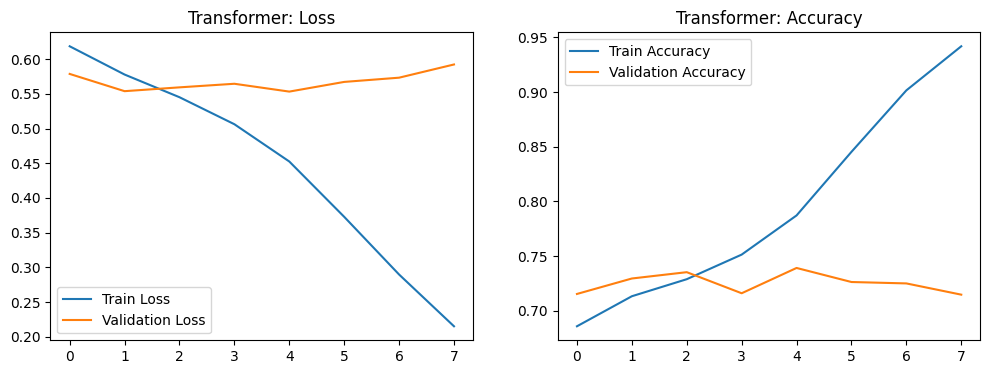

In [ ]:
plot_history(history_trans, 'Transformer')

In [ ]:
evaluate_model(trans, X_test_pad, y_test, 'Transformer')

61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step

Transformer Results:
              precision    recall  f1-score   support

           0       0.70      0.60      0.65       819
           1       0.74      0.81      0.77      1128

    accuracy                           0.72      1947
   macro avg       0.72      0.71      0.71      1947
weighted avg       0.72      0.72      0.72      1947

Accuracy: 0.7227
F1 Score: 0.7720


3. BiLSTM

In [ ]:
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W = Dense(units)
        self.V = Dense(1)

    def call(self, inputs):
        hidden_states = inputs
        score = tf.nn.tanh(self.W(hidden_states))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * hidden_states
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector

def build_attention_bilstm(vocab_size=15000, embedding_dim=256, max_length=200):
    inputs = Input(shape=(max_length,))
    x = Embedding(vocab_size, embedding_dim, input_length=max_length)(inputs)

    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)

    attention = AttentionLayer(64)(x)

    x = Dense(128, activation='relu')(attention)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(0.0005),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
bilstm = build_bilstm()
history_bilstm = bilstm.fit(
        X_train_pad, y_train,
        validation_split=0.2,
        epochs=30,
        batch_size=64,
        callbacks=callbacks,
        verbose=1)

Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.6161 - loss: 0.6395 - val_accuracy: 0.7418 - val_loss: 0.5363 - learning_rate: 5.0000e-04
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.7839 - loss: 0.4690 - val_accuracy: 0.7360 - val_loss: 0.5990 - learning_rate: 5.0000e-04
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.8977 - loss: 0.2727 - val_accuracy: 0.7206 - val_loss: 0.6778 - learning_rate: 5.0000e-04
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.9401 - loss: 0.1700 - val_accuracy: 0.7020 - val_loss: 0.8343 - learning_rate: 5.0000e-04


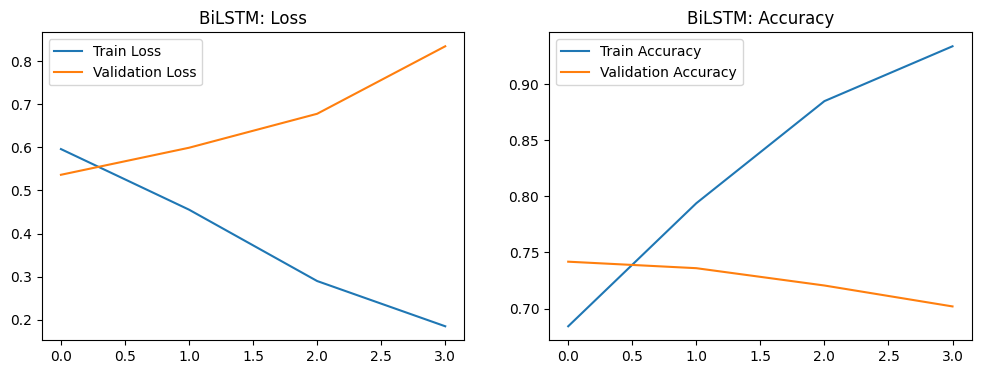

In [ ]:
plot_history(history_bilstm, 'BiLSTM')

In [ ]:
evaluate_model(bilstm, X_test_pad, y_test, 'BiLSTM')

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step

BiLSTM Results:
              precision    recall  f1-score   support

           0       0.67      0.69      0.68       819
           1       0.77      0.76      0.76      1128

    accuracy                           0.73      1947
   macro avg       0.72      0.72      0.72      1947
weighted avg       0.73      0.73      0.73      1947

Accuracy: 0.7278
F1 Score: 0.7634


In [ ]:
results_dl = pd.DataFrame(columns=['Model', 'Accuracy', 'F1-Score'])

results_dl.loc[0] = ['CNN', 0.7114, 0.7656]
results_dl.loc[1] = ['Transformer', 0.7227, 0.7720]
results_dl.loc[2] = ['BiLSTM', 0.7278, 0.7634]

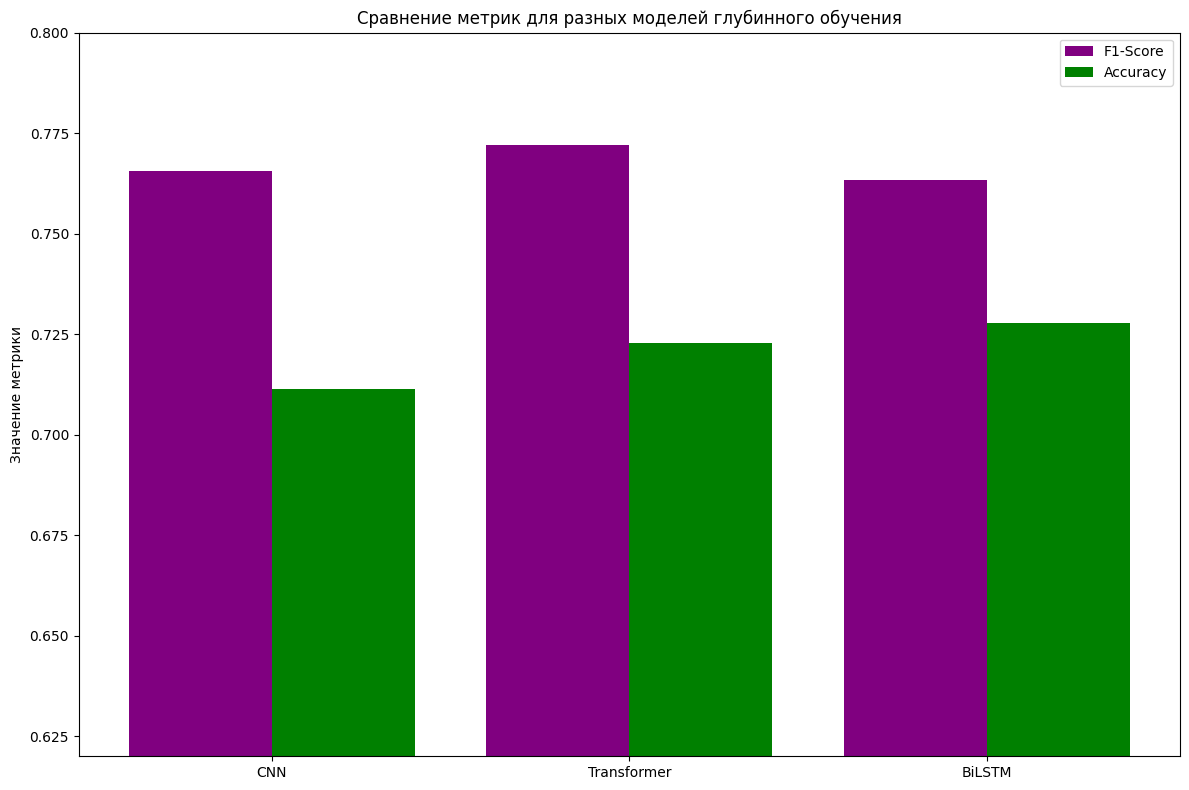

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(results_dl['Model']))
width = 0.4
rects1 = ax.bar(x-width/2, results_dl['F1-Score'], width, label='F1-Score', color='purple')
rects2 = ax.bar(x+width/2, results_dl['Accuracy'], width, label='Accuracy', color='green')
ax.set_ylabel('Значение метрики')
ax.set_title('Сравнение метрик для разных моделей глубинного обучения')
ax.set_xticks(x)
ax.set_xticklabels(results_dl['Model'])
ax.set_ylim(0.62, 0.8)
ax.legend()
plt.tight_layout()
plt.show()

**Вывод:**

Для решения задачи классификации отзывов было использовано 3 различные модели глубинного обучения: BiLSTM с Attention. Для каждой модели были подобраны наилучшие гиперпараметры с помощью экспериментов.

В качестве метрик оценки были выбраны accuracy (доля правильных ответов) и F1-score, который является гармоническим средним между precision (точность) и recall (полнота).

В качестве предобработки данных были использованы очистка текста от стоп-слов, приведение регистра и разбиение текста на токены (Tokenizer). Это позволило настроить текстовые данные для работы моделей глубинного обучения.

По результатам, все модели показали хорошее качество с незначительными различиями,то есть сопоставимые результаты (accuracy в диапазоне от 71% до 73% и F1-Score около 76-77%). **Наилучшее качество по обеим метрикам для решения задачи показала модель трансформеров с полносвязными слоями, незначительно (несколько сотых)уступает ей двунаправленная LSTM с механизмом внимания, чуть похуже результат показала сверточная нейронная сеть**.

Детальный анализ каждой модели:
1. CNN: accuracy: 71.14%, F1-Score: 76.56%.
CNN хорошо справляется с обнаружением локальных паттернов в тексте. Сверточные слои способны улавливать ключевые словосочетания и признаки, указывающие на важность отзыва. Глобальный Max Pooling позволяет выделить наиболее значимые признаки, независимо от их положения в тексте. Хорошо обнаруживает локальные паттерны и ключевые фразы. Относительно простая архитектура и быстрая сходимость по сравнению с рекуррентными моделями.
Недостатки модели в том, что может упускать более длинные и сложные зависимости в тексте по сравнению с моделями, основанными на механизмах внимания или рекуррентных слоях.

2. Transformer: accuracy - 72.27%, F1-Score - 77.20%.
  Transformer использует механизм self-attention, позволяющий модели учитывать взаимосвязи между всеми словами в последовательности, независимо от их расстояния друг от друга. Это позволяет улавливать более сложные зависимости и контекст в тексте. Параллельная обработка позволяет эффективно обучать на больших объемах данных.Механизм внимания позволяет модели фокусироваться на наиболее важных словах при принятии решений.
Недостатки модели в том, что более сложная архитектура и более высокие требования к вычислительным ресурсам по сравнению с CNN. Требует больше данных для эффективного обучения по сравнению с CNN и BiLSTM.

3. BiLSTM: accuracy: 72.78%, F1-Score: 76.34%.
BiLSTM обрабатывает текст в обоих направлениях (прямом и обратном), что позволяет модели учитывать контекст как слева, так и справа от каждого слова. Это особенно полезно для понимания смысла предложений и улавливания зависимостей между словами. Хорошо справляется с последовательной информацией и зависимостями в тексте. Относительно простая архитектура и более быстрая сходимость по сравнению с Transformer.
Недостатки состоят в том, что последовательная обработка может быть медленнее, чем параллельная обработка в CNN и Transformer. Сложно улавливать дальние зависимости в длинных последовательностях текста.

### Сравнительный анализ ML и DL

Модели **глубинного обучения в целом показали более высокие значения F1-Score**, чем модели машинного обучения, что может указывать на их лучшую способность справляться с дисбалансом классов в задаче классификации важности отзывов.
Transformer, BiLSTM, CNN показали хорошие результаты, превзойдя все модели машинного обучения по F1-Score. Это свидетельствует об их способности более эффективно учитывать контекст и сложные зависимости в текстовых данных.

Однако, наилучшей моделью среди всех **по accuracy стала модель машинного обучения Gradient Boosting**, продемонстрировав accuracy 73.60%. Это указывает на способность градиентного бустинга эффективно улавливать нелинейные зависимости в данных и делать точные предсказания.

Преимущества машинного обучения: Более быстрая тренировка, особенно на относительно небольших датасетах. Меньшие требования к вычислительным ресурсам. Лучшая интерпретируемость.
Преимущества глубинного обучения: Способность улавливать более сложные зависимости и контекст в данных. Потенциально более высокая точность на больших датасетах. Автоматическое извлечение признаков, уменьшающее необходимость ручной разработки признаков.

**Таким образом, наилучшими моделями по соотношению двух метрик стали Gradient Boosting, Transformer и BiLSTM.**
